# Optimización del Gasto de Marketing: CAC vs LTV  de **SHOWZ**

Showz es una empresa de venta de entradas de eventos que busca optimizar los gastos de marketing. 

Se cuenta con la siguiente data:

* registros del servidor con datos sobre las visitas a Showz desde enero de 2017 hasta diciembre de 2018.
* un archivo con los pedidos en este periodo.
* estadísticas de gastos de marketing.

✨ **¿Estamos invirtiendo bien en adquisición de clientes?**  
Este notebook responde a esa pregunta analizando el equilibrio entre:  
- 🎯 **CAC (Customer Acquisition Cost)** → Lo que cuesta traer un cliente.  
- 💰 **LTV (Customer Lifetime Value)** → Lo que ese cliente genera en ingresos a lo largo del tiempo.  


## Objetivos
- 📌 Calcular el **CAC promedio**.  
- 📌 Estimar el **LTV promedio**.  
- 📌 Comparar **LTV vs CAC** para evaluar sostenibilidad.  
- 📌 Proponer **estrategias de optimización de marketing**. 

## Importación de Librerias

In [1]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as st 
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_costs = pd.read_csv('/datasets/costs_us.csv')
df_orders = pd.read_csv('/datasets/orders_log_us.csv')
df_visits = pd.read_csv('/datasets/visits_log_us.csv')

## Diagnóstico Inicial

In [3]:
#Funcion para el diagnóstico inicial de los datos
def fun_diagnóstico (df):
    print("ESTRUCTURA GENERAL")
    print(df.info())
    print()
    print("MUESTRA DE LOS DATOS")
    print(df.sample(5))

In [4]:
# Diagnostico df_costs
print("Diagnostico del DATAFRAME Costs")
print(fun_diagnóstico(df_costs))

Diagnostico del DATAFRAME Costs
ESTRUCTURA GENERAL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None

MUESTRA DE LOS DATOS
      source_id          dt   costs
2051          9  2018-01-22   23.39
992           3  2018-02-22  769.47
849           3  2017-10-02  558.33
336           1  2018-05-05   19.20
1109          4  2017-06-21   52.60
None


In [5]:
# Diagnostico df_orders
print("Diagnostico del DATAFRAME Orders")
print(fun_diagnóstico(df_orders))

Diagnostico del DATAFRAME Orders
ESTRUCTURA GENERAL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None

MUESTRA DE LOS DATOS
                    Buy Ts  Revenue                  Uid
30957  2018-01-25 12:31:00     0.85  6406437071844833233
14456  2017-10-25 10:21:00     1.83  6731421022966725351
13328  2017-10-18 10:09:00     6.72  9623486034035993750
42799  2018-04-02 13:27:00     1.71  7126039349442663254
6215   2017-08-28 16:14:00     0.30  5603453646174104178
None


In [6]:
# Diagnostico df_visits
print("Diagnostico del DATAFRAME Visits")
print(fun_diagnóstico(df_visits))

Diagnostico del DATAFRAME Visits
ESTRUCTURA GENERAL
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None

MUESTRA DE LOS DATOS
         Device               End Ts  Source Id             Start Ts  \
296424  desktop  2018-04-04 12:57:00          4  2018-04-04 12:56:00   
93327     touch  2017-11-09 22:34:00          5  2017-11-09 22:34:00   
50228   desktop  2018-02-21 03:06:00          2  2018-02-21 02:52:00   
143239  desktop  2017-08-22 13:19:00          2  2017-08-22 13:01:00   
139602    touch  2017-07-17 11:04:00          2  2017-07-17 10:56:00   

                         Uid  
29642


## Observaciones del Diagnóstico Inicial


**El dataframe costs** contiene sobre gastos de marketing. Contiiene 2542 entradas con 3 Columnas, no cuenta con datos ausentes. 

- **source_id: identificador de la fuente de anuncios.** Del tipo int64 es correcto para esta columna.

- **dt: fecha.** Del tipo object sera convertido al tipo datetime para poder realizar las metricas correspondietes.
  
- **costs: gastos en esta fuente de anuncios en este día.** Del tipo floar64 adecuado para esta columna.


**El dataframe orders** guarda datos sobre pedidos. Contiene 50415 entradas con 3 Columnas, no cuenta con datos ausentes.

- **Buy Ts: fecha y hora del pedido.** Del tipo object sera convertido al tipo datetime para poder realizar las metricas correspondietes.

- **Revenue: el ingreso de Showz por el pedido.** Del tipo floar64 adecuado para esta columna.

- **Uid: identificador único del usuario que realiza un pedido.**  Del tipo uint64 es un tipo de dato que representa enteros sin signo de 64 bits.


**El dataframe visits muestra los registros del servidor con datos sobre las visitas al sitio web.** Contiene 359400 con 5 Columnas, no contiene datos ausentes.

- **Uid: identificador único del usuario.**  Del tipo uint64
  
- **Device: dispositivo del usuario.** Del tipo object adecuado para la columna.

- **Start Ts: fecha y hora de inicio de la sesión.**  Del tipo object sera convertido al tipo datetime para poder realizar las metricas correspondietes.

- **End Ts: fecha y hora de término de la sesión.**  Del tipo object sera convertido al tipo datetime para poder realizar las metricas correspondietes.

- **Source Id: identificador de la fuente de anuncios de la que proviene el usuario.** Del tipo int64 es correcto para esta columna.


## Plan de Trabajo

- Los dataframes de **orders y visits presentan mayuculas y espacios en los nombres de las columnas, se covertiran al formato snake_case para estandarizar.

- Convetir las columnas ya mencionadas al tipo datetime

In [7]:
# Formato snake_case para los nombres de columnas en orders y visits
df_orders.columns = df_orders.columns.str.strip().str.lower().str.replace(' ', '_')
df_visits.columns = df_visits.columns.str.strip().str.lower().str.replace(' ', '_')

In [8]:

# Conversión de Columnas al tipo datetime
# dataframe costs
df_costs['dt'] = pd.to_datetime(df_costs['dt'], format = '%Y-%m-%d %H:%M:%S')
# dataframe orders
df_orders['buy_ts'] = pd.to_datetime(df_orders['buy_ts'],format = '%Y-%m-%d %H:%M:%S')
# dataframe visits
df_visits['start_ts'] = pd.to_datetime(df_visits['start_ts'], format = '%Y-%m-%d %H:%M:%S')
df_visits['end_ts'] = pd.to_datetime(df_visits['end_ts'], format = '%Y-%m-%d %H:%M:%S')


In [9]:
# Mostrar la información de los dataframes para verificar los cambios
print("Información del DataFrame 'visits':")
df_visits.info()
print("\nInformación del DataFrame 'orders':")
df_orders.info()
print("\nInformación del DataFrame 'costs':")
df_costs.info()

Información del DataFrame 'visits':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB

Información del DataFrame 'orders':
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 

# Actividad del usuario

## Promedio de uso por Día, Semana y Mes

In [10]:
# Extrae mes, semana, día de cada sesion y crea la columna   
df_visits['year_sess'] = df_visits['start_ts'].dt.isocalendar().year
df_visits['month_sess'] = df_visits['start_ts'].dt.month
df_visits['week_sess'] = df_visits['start_ts'].dt.isocalendar().week
df_visits['day_sess'] = df_visits['start_ts'].dt.date

In [11]:
# Calcula la metrica DAU WAU y MAU
dau_total = (
    df_visits
    .groupby(['day_sess'])
    .agg({'uid': 'nunique'})
    .mean()
)

wau_total = (
    df_visits
    .groupby(['month_sess', 'week_sess'])
    .agg({'uid': 'nunique'})
    .mean()
)
mau_total = (
    df_visits
    .groupby(['month_sess'])
    .agg({'uid': 'nunique'})
    .mean()
)

print(f"Número promedio de usuarios únicos por día (DAU):", dau_total)
print(f"Número promedio de usuarios únicos por semana (WAU):", wau_total)
print(f"Número promedio de usuarios únicos por mes (MAU):", mau_total)

Número promedio de usuarios únicos por día (DAU): uid    907.991758
dtype: float64
Número promedio de usuarios únicos por semana (WAU): uid    4911.129032
dtype: float64
Número promedio de usuarios únicos por mes (MAU): uid    23228.416667
dtype: float64


## Promedio de sesiones por Día

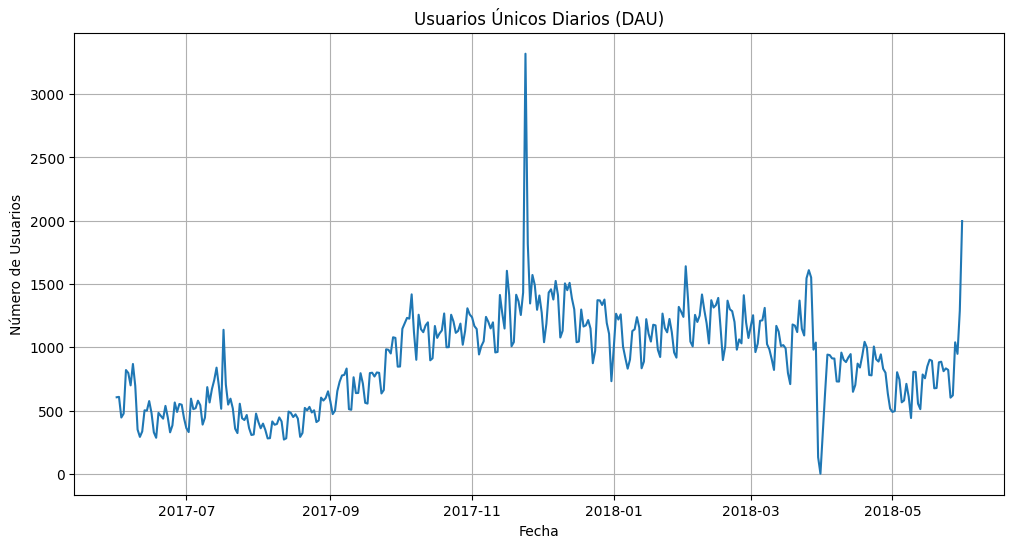

In [12]:
# Usuarios Únicos Diarios (DAU) a lo largo del tiempo
daily_users = df_visits.groupby(df_visits['start_ts'].dt.date)['uid'].nunique()
daily_users.plot(figsize=(12, 6), title='Usuarios Únicos Diarios (DAU)')
plt.xlabel('Fecha')
plt.ylabel('Número de Usuarios')
plt.grid(True)
plt.show()

In [13]:
# Calcula el conteo y el número de sesiones únicas por grupo
sessions_per_day = df_visits.groupby('day_sess').size().mean()
print(f"\nNúmero promedio de sesiones por día: {sessions_per_day:.2f}")


Número promedio de sesiones por día: 987.36


## Promedio de la duración por sesión

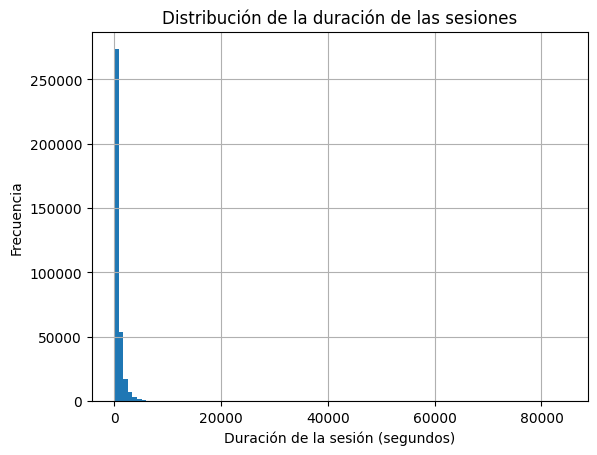


Duración promedio de la sesión: 643.51 segundos

Duración promedio de la sesión: 10.73 minutos


In [14]:
# Encuentra la duración de las sesiones
df_visits['session_duration_sec'] = (df_visits['end_ts'] - df_visits['start_ts']).dt.seconds
# Calcula ASL
asl = df_visits['session_duration_sec'].mean()
# Grafica
df_visits['session_duration_sec'].hist(bins=100)
plt.xlabel('Duración de la sesión (segundos)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la duración de las sesiones')
plt.show()

print(f"\nDuración promedio de la sesión: {asl:.2f} segundos")
print(f"\nDuración promedio de la sesión: {asl/60:.2f} minutos")

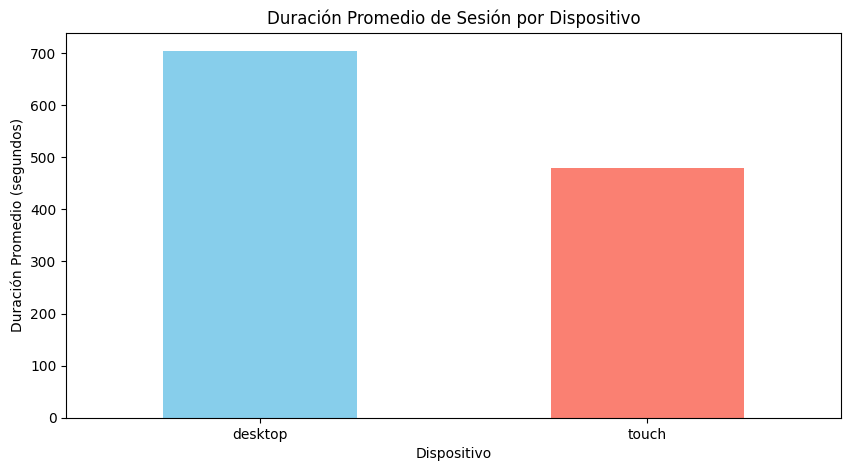

In [15]:
# Duración de la sesión por dispositivo
avg_duration_by_device = df_visits.groupby('device')['session_duration_sec'].mean().reset_index()
avg_duration_by_device.plot(
    x='device', xlabel= 'Dispositivo',
    y='session_duration_sec', ylabel= 'Duración Promedio (segundos)',
    kind='bar',
    figsize=(10,5),
    title='Duración Promedio de Sesión por Dispositivo',
    color=['skyblue', 'salmon'],
    legend=False
)
plt.xticks(rotation=0)
plt.show()

## Sticky Factor

In [16]:
# Calcula Sticky Factor
sticky_wau = (dau_total / wau_total) * 100
print(sticky_wau)
sticky_mau = (dau_total / mau_total) * 100
print(sticky_mau)

uid    18.488452
dtype: float64
uid    3.90897
dtype: float64


## * Conclusiones del Análisis del Comportamiento del Usuario y Métricas Clave (DAU, WAU, MAU)*

El análisis del comportamiento de los usuarios en la plataforma de Showz revela una base de clientes estable y activa. Las métricas de uso diario, semanal y mensual (DAU, WAU y MAU) confirman que el servicio es utilizado con regularidad a lo largo del tiempo.

Usuarios diarios (DAU): El promedio de 908 usuarios únicos por día demuestra una interacción constante con la plataforma. Este dato es fundamental para medir la salud del negocio y la efectividad de las campañas de marketing que buscan atraer tráfico diario.

Usuarios semanales (WAU) y mensuales (MAU): Los promedios de 4,911 usuarios semanales y 23,228 usuarios mensuales indican una base de usuarios fiel y recurrente. El crecimiento sostenido o la estabilidad en estas métricas sugiere que Showz tiene una propuesta de valor sólida que mantiene a los usuarios comprometidos.

# Marketing

## Tasa de Retención General

In [17]:
# Encontrar la primera fecha de actividad de cada usuario en un objeto Series (columna) y nombrarla
first_activity_date = df_visits.groupby(['uid'])['start_ts'].min()
first_activity_date.name = 'first_activity_date'

# Unión de la primera fecha de actividad con los datos de actividad del usuario,  agrupamos por usuario (user_id) y nos quedamos con la fecha mínima para cada usuario
df_visits = df_visits.join(first_activity_date, on='uid')

# Creación de una nueva columna 'activity_month' para representar el inicio de semana para cada fecha de actividad.
# Define la cohorte como el mes de la primera visita
df_visits['first_activity_month'] = df_visits['first_activity_date'].dt.to_period('M')
# Define el mes de la visita actual
df_visits['visit_month'] = df_visits['start_ts'].dt.to_period('M')

# Calcula la diferencia en tiempo entre el mes de actividad actual y el primer mes de actividad
df_visits['cohort_lifetime'] = (df_visits['visit_month'] - df_visits['first_activity_month']).apply(lambda x: x.n)

# Agrupa los datos por cohorte y tiempo de vida, contando usuarios únicos en cada combinación
cohort_months = df_visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
# Original hasta aqui
# Crea una tabla pivote para visualizar los datos de retención de manera clara
retention_pivot = cohort_months.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='uid')

# Calcula el tamaño de la cohorte (número de usuarios en el mes 0)
cohort_sizes = retention_pivot.iloc[:, 0]

# Divide el conteo de usuarios por el tamaño de la cohorte para obtener la tasa de retención
retention_rate = retention_pivot.divide(cohort_sizes, axis=0) * 100

print("Tabla de Retención Mensual (%):")
print(retention_rate.round(2))

Tabla de Retención Mensual (%):
cohort_lifetime          0     1     2     3     4     5     6     7     8   \
first_activity_month                                                          
2017-06               100.0  7.87  5.38  6.14  6.86  7.14  6.10  5.78  5.23   
2017-07               100.0  5.61  5.13  5.62  5.82  4.82  4.54  4.57  3.88   
2017-08               100.0  7.69  6.29  6.28  5.01  4.40  3.63  3.95  2.79   
2017-09               100.0  8.55  6.92  5.07  3.94  3.78  3.59  2.42  2.28   
2017-10               100.0  7.86  5.22  3.90  3.43  3.22  2.14  2.04   NaN   
2017-11               100.0  7.83  4.41  3.87  3.37  2.34  2.18   NaN   NaN   
2017-12               100.0  5.58  3.80  3.11  2.03  1.90   NaN   NaN   NaN   
2018-01               100.0  5.97  3.93  2.50  2.02   NaN   NaN   NaN   NaN   
2018-02               100.0  5.71  2.55  2.01   NaN   NaN   NaN   NaN   NaN   
2018-03               100.0  4.18  2.71   NaN   NaN   NaN   NaN   NaN   NaN   
2018-04             

## Gráfica de la Tasa de Retención agrupada por Mes

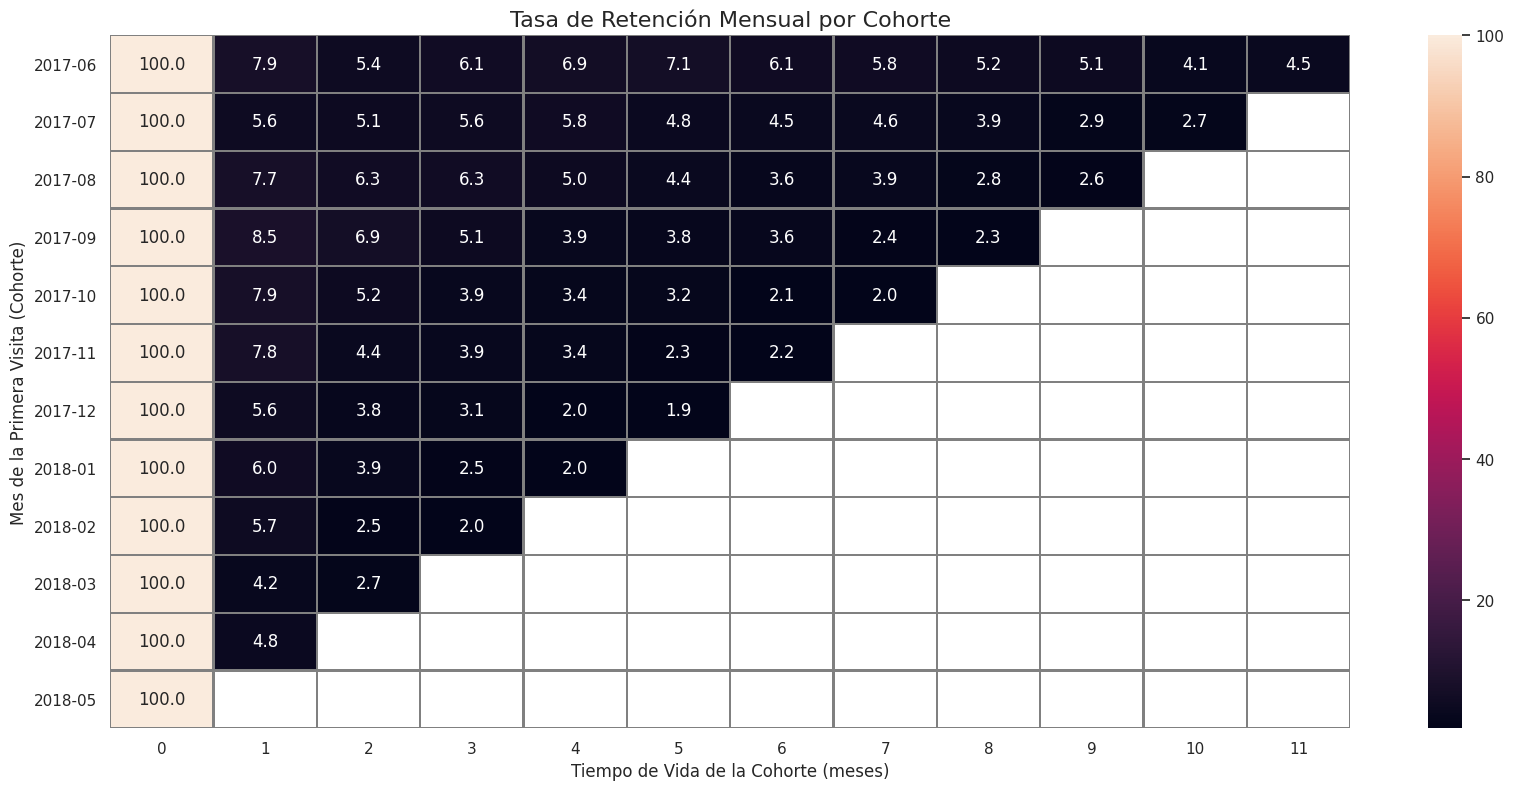

In [23]:
# Crea un mapa de Calor
sns.set(style='white')
plt.figure(figsize=(20, 9))
sns.heatmap(
retention_rate, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.title('Tasa de Retención Mensual por Cohorte', fontsize=16)
plt.xlabel('Tiempo de Vida de la Cohorte (meses)', fontsize=12)
plt.ylabel('Mes de la Primera Visita (Cohorte)', fontsize=12, )
plt.show()

## Tasa de retención por dispositivo 

In [24]:
#Tasa de retención por Dispositivo "desktop"
df_visits_desktop = df_visits[df_visits['device'] == 'desktop'].reset_index()
# tasa de retencion unicamente para device=desktop
df_visits_desktop = df_visits_desktop.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes_desktop = df_visits_desktop.groupby('first_activity_month')['uid'].first()
retention_rate_desktop = df_visits_desktop.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='uid').divide(cohort_sizes_desktop, axis=0) * 100

#Tasa de retención por Dispositivo "touch"
df_visits_touch = df_visits[df_visits['device'] == 'touch'].reset_index()
# tasa de retencion unicamente para device = touch
df_visits_touch = df_visits_touch.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes_touch = df_visits_touch.groupby('first_activity_month')['uid'].first()
retention_rate_touch = df_visits_touch.pivot_table(index='first_activity_month', columns='cohort_lifetime', values='uid').divide(cohort_sizes_touch, axis=0) * 100



## Grafica para tasa de retención por dispositivo

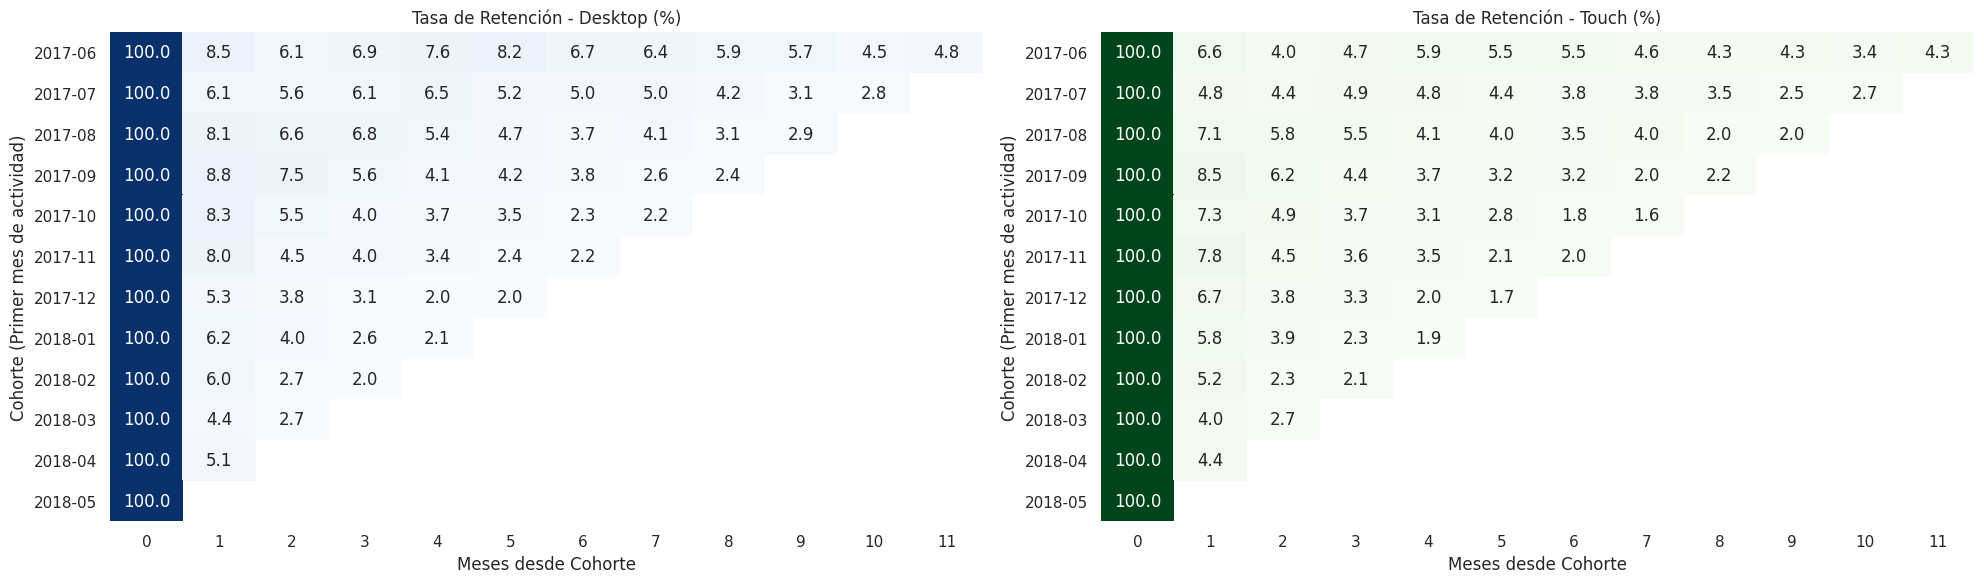

In [25]:
# Grafica para tasa de retención por dispositivo lado a lado

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.heatmap(
    retention_rate_desktop, 
    annot=True, fmt=".1f", cmap="Blues", cbar=False
)
plt.title("Tasa de Retención - Desktop (%)")
plt.xlabel("Meses desde Cohorte")
plt.ylabel("Cohorte (Primer mes de actividad)")

# Heatmap para Touch
plt.subplot(1, 2, 2)
sns.heatmap(
    retention_rate_touch, 
    annot=True, fmt=".1f", cmap="Greens", cbar=False
)
plt.title("Tasa de Retención - Touch (%)")
plt.xlabel("Meses desde Cohorte")
plt.ylabel("Cohorte (Primer mes de actividad)")

plt.tight_layout()
plt.show()

## Tiempo de conversión de Usuario a Cliente

In [26]:
# Encontramos la fecha de la primera visita y la primera compra para cada usuario
first_activity_data = df_visits.groupby('uid').agg(
    first_activity_date=('first_activity_date', 'min'),
    mkt_source=('source_id', 'first')
).reset_index()

first_order_data = df_orders.groupby('uid').agg(
    first_order=('buy_ts', 'min'),
    revenue_total=('revenue', 'sum')
).reset_index()

# Union los DataFrames para crear el DataFrame final
# Se utiliza 'inner' para unir solo a los usuarios que visitaron y compraron
df_ventas = pd.merge(first_activity_data, first_order_data, on='uid', how='inner')

# Calcular el tiempo de conversión
df_ventas['time_to_convert'] = (df_ventas['first_order'] - df_ventas['first_activity_date']).dt.days

In [27]:
# Calculamos el promedio de tiempo de conversión
avg_time_to_convert = df_ventas['time_to_convert'].mean()
print(f"Tiempo promedio de conversión (días): {avg_time_to_convert:.2f}")

Tiempo promedio de conversión (días): 16.73


## Número de pedidos por al DIA, SEMANA y MES

In [28]:
# Conteo los pedidos por día, semana y mes
orders_by_date = df_orders.groupby(df_orders['buy_ts'].dt.date).size()
orders_by_week = df_orders.groupby(df_orders['buy_ts'].dt.isocalendar().week).size()
orders_by_month = df_orders.groupby(df_orders['buy_ts'].dt.month).size()

print("\nPedidos por día (promedio):", orders_by_date.mean().round(2))
print("Pedidos por semana (promedio):", orders_by_week.mean().round(2))
print("Pedidos por mes (promedio):", orders_by_month.mean().round(2))


Pedidos por día (promedio): 138.5
Pedidos por semana (promedio): 969.52
Pedidos por mes (promedio): 4201.25


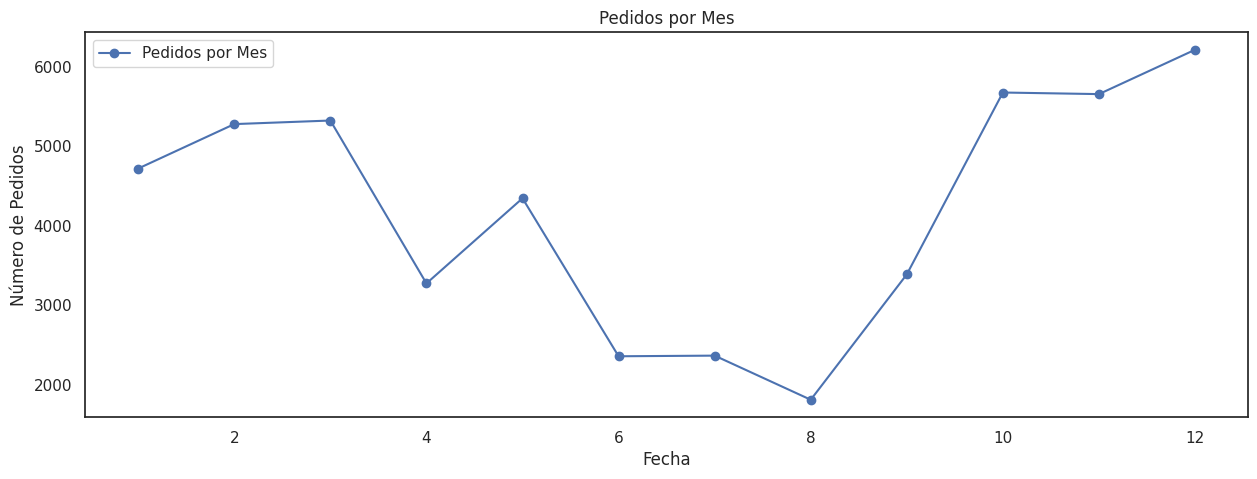

In [29]:
#Grafica de linea de pedidos y agrupado por mes
plt.figure(figsize=(15, 5))
plt.plot(orders_by_month.index, orders_by_month.values, label='Pedidos por Mes', marker='o')
plt.title('Pedidos por Mes')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.legend()
plt.show()

## Tamaño promedio de la compra

In [30]:
# ¿Cuál es el tamaño promedio de compra? (Ticket promedio)
avg_revenue_per_order = df_orders['revenue'].mean()
print(f"\nTamaño promedio de compra (Ticket Promedio): ${avg_revenue_per_order:.2f}")


Tamaño promedio de compra (Ticket Promedio): $5.00


## Valor de Vida del Cliente (LTV)

In [50]:
df_visits.head(5)

,device,end_ts,source_id,start_ts,uid,year_sess,month_sess,week_sess,day_sess,session_duration_sec,first_activity_date,first_activity_month,visit_month,cohort_lifetime,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12,2017-12,0,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19 16:53:00,2018-02,2018-02,0,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01 01:54:00,2017-07,2017-07,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09 20:05:00,2018-03,2018-05,2,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27 14:06:00,2017-12,2017-12,0,2017-12-27


In [52]:
# Cohorte de cada usuario (mes de la primera visita y fuente)
first_activity = df_visits.groupby('uid').agg(
    first_activity_date=('start_ts', 'min'),
    source_id=('source_id', 'first')
).reset_index()

# Mes de la primera visita para definir la cohorte
first_activity['cohort_month'] = first_activity['first_activity_date'].dt.to_period('M')

# Ingresos por usuario
# Sumar los ingresos de cada usuario en el dataframe de órdenes
revenue_by_user = df_orders.groupby('uid')['revenue'].sum().reset_index()
revenue_by_user.rename(columns={'revenue': 'total_revenue'}, inplace=True)

# Union ingresos a los datos de cohorte
cohort_data = pd.merge(first_activity, revenue_by_user, on='uid', how='left')

# Si un usuario no compró, sus ingresos son 0
cohort_data['total_revenue'] = cohort_data['total_revenue'].fillna(0)

# Costos por cohorte (agrupado por mes y fuente)
# Asegurar que el mes en df_costs sea del mismo tipo que la cohorte
df_costs['cohort_month'] = df_costs['dt'].dt.to_period('M')
costs_by_cohort = df_costs.groupby(['cohort_month', 'source_id'])['costs'].sum().reset_index()
costs_by_cohort.rename(columns={'costs': 'total_costs'}, inplace=True)

# Unión todos los datos para calcular LTV, CAC y ROMI
# a) Contar el número de usuarios por cohorte
users_by_cohort = cohort_data.groupby(['cohort_month', 'source_id'])['uid'].nunique().reset_index()
users_by_cohort.rename(columns={'uid': 'users_count'}, inplace=True)

# b) Sumar los ingresos totales por cohorte
revenue_by_cohort = cohort_data.groupby(['cohort_month', 'source_id'])['total_revenue'].sum().reset_index()

# c) Unir todos los dataframes
final_metrics = pd.merge(users_by_cohort, revenue_by_cohort, on=['cohort_month', 'source_id'])
final_metrics = pd.merge(final_metrics, costs_by_cohort, on=['cohort_month', 'source_id'])

final_metrics['ltv'] = final_metrics['total_revenue'] / final_metrics['users_count']
print("Métricas de Cohorte (LTV):")
print(final_metrics.head(10))

Métricas de Cohorte (LTV):
  cohort_month  source_id  users_count  total_revenue  total_costs        ltv
0      2017-06          1          763       12248.31      1125.61  16.052831
1      2017-06          2         1396       10657.15      2427.38   7.634062
2      2017-06          3         3830        4840.42      7731.65   1.263817
3      2017-06          4         3461        6252.04      3514.80   1.806426
4      2017-06          5         2700        4885.77      2616.12   1.809544
5      2017-06          9          709         850.79       285.22   1.199986
6      2017-06         10          397         291.57       314.22   0.734433
7      2017-07          1          694        2767.34      1072.88   3.987522
8      2017-07          2         1334        3145.37      2333.11   2.357849
9      2017-07          3         3469        3381.19      7674.37   0.974687


# Análisis de Marketing

In [31]:
# --- Métricas de Marketing ---

# Union los datos de visitas y costos
df_visits['date'] = df_visits['start_ts'].dt.date
df_costs['date'] = df_costs['dt'].dt.date
daily_costs = df_costs.groupby('date')['costs'].sum().reset_index()
daily_users = df_visits.groupby('date')['uid'].nunique().reset_index()

# Union costos y usuarios por día
marketing_metrics = pd.merge(daily_costs, daily_users, on='date', how='outer').fillna(0)
marketing_metrics['costs_per_user'] = marketing_metrics['costs'] / marketing_metrics['uid']


## Inversion para cada fuente de adquisición

In [32]:
# Total del costo por fuente de adquisicipon
total_costs = df_costs['costs'].sum()
print(f"Costo total de marketing: ${total_costs:.2f}")

costs_by_source = df_costs.groupby('source_id')['costs'].sum().reset_index()
print("\nCosto total por fuente de adquisición:")
print(costs_by_source)



Costo total de marketing: $329131.62

Costo total por fuente de adquisición:
   source_id      costs
0          1   20833.27
1          2   42806.04
2          3  141321.63
3          4   61073.60
4          5   51757.10
5          9    5517.49
6         10    5822.49


## Costo de Adquisición por cada fuente (CAC)

In [28]:
# Primera visita para cada usuario para asignarles una fuente
first_visit_source = df_visits.groupby('uid')['start_ts'].min().reset_index()
first_visit_source.columns = ['uid', 'first_visit']

# Unión con las visitas para obtener la fuente de la primera visita
first_visit_source = pd.merge(first_visit_source, df_visits[['uid', 'start_ts', 'source_id']], 
                              left_on=['uid', 'first_visit'], right_on=['uid', 'start_ts'])

# Conteo de usuarios únicos por fuente
new_users_by_source = first_visit_source.groupby('source_id')['uid'].nunique().reset_index()
new_users_by_source.columns = ['source_id', 'new_users']

# Unión con los costos para calcular el CAC
costs_by_source = pd.merge(costs_by_source, new_users_by_source, on='source_id')
costs_by_source['cac'] = costs_by_source['costs'] / costs_by_source['new_users']

print("\nCosto de Adquisición de Clientes (CAC) por fuente:")
print(costs_by_source)



Costo de Adquisición de Clientes (CAC) por fuente:
   source_id      costs  new_users       cac
0          1   20833.27       9469  2.200155
1          2   42806.04      17616  2.429952
2          3  141321.63      66116  2.137480
3          4   61073.60      72346  0.844188
4          5   51757.10      49237  1.051183
5          9    5517.49       6448  0.855690
6         10    5822.49       6903  0.843472


## Rentabilidad de las inversiones

In [29]:
# ¿Cuán rentables eran las inversiones? (ROMI)
# Para el ROMI, necesitamos los ingresos por cohorte de fuente
cohort_revenue = pd.merge(first_visit_source, df_orders, on='uid', how='inner')
cohort_revenue = cohort_revenue.groupby('source_id')['revenue'].sum().reset_index()

# Unión con los costos para calcular el ROMI
romi_data = pd.merge(costs_by_source, cohort_revenue, on='source_id')
romi_data['romi'] = romi_data['revenue'] / romi_data['costs']

print("\nRetorno de la Inversión en Marketing (ROMI) por fuente:")
print(romi_data[['source_id', 'romi']].sort_values(by='romi', ascending=False))



Retorno de la Inversión en Marketing (ROMI) por fuente:
   source_id      romi
0          1  1.492351
1          2  1.096191
5          9  1.043844
4          5  1.016750
3          4  0.928336
6         10  0.764335
2          3  0.385725


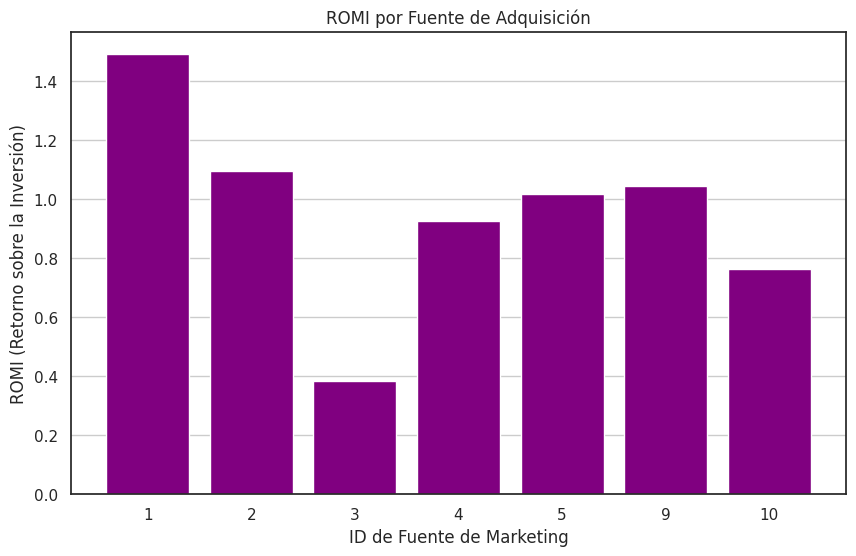

In [30]:
# ROMI por fuente de adquisición
plt.figure(figsize=(10, 6))
plt.bar(romi_data['source_id'].astype(str), romi_data['romi'], color='purple')
plt.title('ROMI por Fuente de Adquisición')
plt.xlabel('ID de Fuente de Marketing')
plt.ylabel('ROMI (Retorno sobre la Inversión)')
plt.grid(axis='y')
plt.show()

# *Recomendaciones Estratégicas para la Optimización de Marketing*

El análisis del cálculo del Costo de Adquisición de Clientes (CAC) y el Retorno sobre la Inversión en Marketing (ROMI), es fundamental para tomar decisiones estratégicas. Basado en el análisis previo, las recomendaciones para el equipo de marketing son las siguientes:

- Priorizar la rentabilidad sobre el volumen: 

El objetivo no es solo atraer a más usuarios (CAC bajo), sino a los usuarios que generan un mayor valor de por vida (LTV). La métrica más importante es el ROMI, ya que indica si las campañas publicitarias están generando más ingresos de lo que cuestan.

- Redistribuir el presupuesto: 

Se recomienda identificar y aumentar la inversión en las fuentes de marketing que presenten un ROMI positivo y alto, lo que indica que están atrayendo clientes de alto valor. Por el contrario, las fuentes con un ROMI bajo o negativo deben ser reevaluadas; si no mejoran, su presupuesto debe ser reducido o eliminado.

- Enfoque en el LTV: 

Es crucial continuar analizando el Valor de por Vida del Cliente (LTV) por cada cohorte de adquisición. Al entender qué fuentes de tráfico traen a los clientes más valiosos a largo plazo, el equipo de marketing puede tomar decisiones más informadas y garantizar un crecimiento sostenible para la empresa.

**En resumen, Showz tiene una base de usuarios sólida y activa. El siguiente paso para optimizar los gastos de marketing es utilizar los datos para identificar y capitalizar las campañas que atraen a los clientes más rentables, enfocándose en la maximización del ROMI y el LTV.**